# NLP - Github Programming Language Prediction

09/07/2022

- Chenchen Feng, Jess Gardin, Jarrid Jones

## Project Goals

Determine the programming language used in the code of a online github repos based on the contents of the READM.md.

## Project Description

Inflation is an ongoing concern for many. We looked at github to see there are over 1,000 publicly available repos addressing inflation. We took a sample and after filtering out repos that do not have a readme, we ended up with a little over 500 repos to analyze.

## Initial Questions

    1. The word choice in the Readme will vary by programmiing language.
    2. The Readme will vary in length based on programmiing language.
    3. What are the most common words in Python, JavaScript and R besides the key word inflation?
    4. Are there any words that uniquely identify a programming language?

## Data Dictionary

* repo: Github repo name.
* language: main computing language used by this repo.
* readme_contents: README content of this repo.
* clean: lowercase, unicoded, nonalphnumeric or spaces removed, tokenized, removed stopwords, lemmatized	
* all: all readmes regardless of langauge
* python: all readmes labeled 'Python' by github
* javascript: all readmes labeled 'javascript' by github
* r: all readmes labeled 'R' by github
* other: readmes labeled by github as any other language than Python, JavaScript, or R
* readme_lenth: the lenth of readme.

## Libraries

In [1]:
import re
import unicodedata
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Wrangle Data

### Acquite Data

1. Picking topic: The topic we choose to scarp on Github is inflation, there are abour 884 results from this topic.
2. Get repo names related to inflaton, then save in repo_name.csv file.
3. Get README content and computing language with the repo name we get from step 2, then same in inflation_readme.csv file.


In [10]:
df = pd.read_csv('inflation_readme.csv', index_col=0)
df.shape

(848, 3)

## Clean Data

1. Missing value: drop all the missing value since there is no way we can predic anything if the readme content or language has no value.
2. Rename: after our investigation, most of the Jupyter note language type are actually python, so we merge Jupyter notebook into python. Also we only choose to use the top three computing language, rename the rest languages to 'other'.

In [11]:
import prepare
df = prepare.prepare_df(df)
df.shape

(523, 5)

## Split Data
* Split the data into train 56%, validate 24%, test 20%.
* Our data is now split into 3 samples so that we can use the train sample to explore, fit to models and evaluate without looking at new data.
* The validate is used to verify that our models built are not overfit to the train dataset and get the best model.
* The test set is used to give an estimate of how this model will perform on data is has never seen in the future.

In [6]:
train, validate, test = prepare.split_data_for_explore(df)

## Data Context

We scraped 848 repos total. After dropping the null values, we have 523 repos left.

<AxesSubplot:xlabel='language', ylabel='count'>

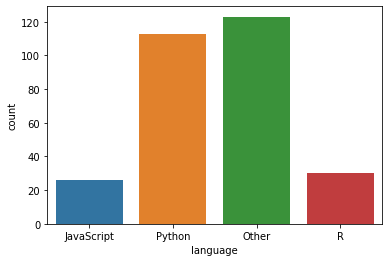

In [12]:
# this is a overview of the computing langiage count
sns.countplot(x='language', data=train)

## Data Exploration

In [13]:
python_words = prepare.clean_for_explore(' '.join(train[train.language == 'Python'].readme_contents))
javascript_words = prepare.clean_for_explore(' '.join(train[train.language == 'JavaScript'].readme_contents))
r_words = prepare.clean_for_explore(' '.join(train[train.language == 'R'].readme_contents))
other_words = prepare.clean_for_explore(' '.join(train[train.language == 'Other'].readme_contents))
all_words = prepare.clean_for_explore(' '.join(train.readme_contents))

python_freq = pd.Series(python_words).value_counts()
javascript_freq = pd.Series(javascript_words).value_counts()
r_freq = pd.Series(r_words).value_counts()
other_freq = pd.Series(other_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

word_counts = (pd.concat([all_freq, python_freq, javascript_freq,r_freq, other_freq], axis=1, sort=True)
                .set_axis(['all', 'python', 'javascript','r','other'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

### 1. What are the most common words in all READMEs related to the inflation topic?

Text(0.5, 1.0, 'All Readme Word Cloud')

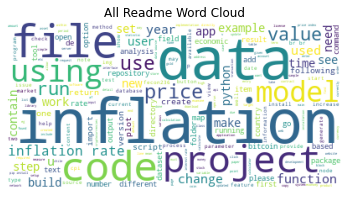

In [18]:
all_cloud = ' '.join(all_words)
img = WordCloud(background_color='white').generate(all_cloud)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('All Readme Word Cloud')

* inflation, data, file, price, code are the top five in all words.

### 2. Does the length of the README vary by programming language?

In [37]:
train['readme_lenth'] = train.lemmatized.str.len()
train.groupby('language').readme_lenth.mean().sort_values(ascending=False)

language
Python        1107.265487
Other          990.040650
JavaScript     911.423077
R              834.333333
Name: readme_lenth, dtype: float64

<AxesSubplot:xlabel='language', ylabel='readme_lenth'>

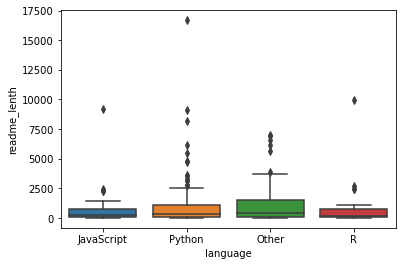

In [40]:
sns.boxplot(x='language', y='readme_lenth', data=train)

* Not true. The lengths of readmes are very close. Even python has the highest average, but due to the outlier in python shown in the chart could make the average greater than it should be, we can NOT say that the length of the README vary by programming language.

### 3. What are the most common words in python, javascript and R besides the keyword inflation?

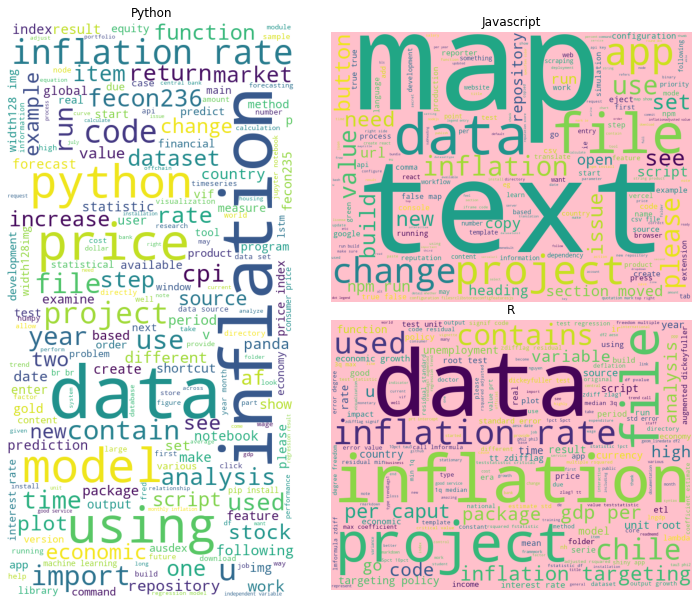

In [52]:
python_cloud = WordCloud(background_color='white', height=1000, width=500).generate(' '.join(python_words))
javascript_cloud = WordCloud(background_color='pink', height=600, width=800).generate(' '.join(javascript_words))
r_cloud = WordCloud(background_color='pink', height=600, width=800).generate(' '.join(r_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(python_cloud)
axs[1].imshow(javascript_cloud)
axs[2].imshow(r_cloud)

axs[0].set_title('Python')
axs[1].set_title('Javascript')
axs[2].set_title('R')

for ax in axs: ax.axis('off')

#### Tp five words:
* Python: data, price, rate, model, python
* Javascript: map, file, text, run, data
* R: data, r, rate, project, test

### 4. Are there any words that uniquely identify a programming language?

Text(0.5, 1.0, 'Top 20 most common words')

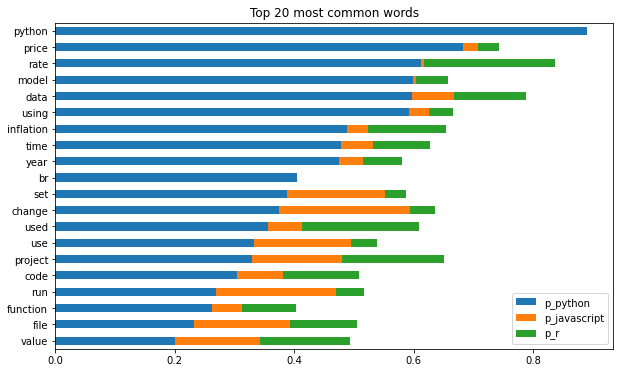

In [60]:
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_javascript=word_counts.javascript / word_counts['all'],
         p_r=word_counts.r / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_javascript','p_r']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True,figsize=(10, 6)))

plt.title('Top 20 most common words')

Text(0.5, 1.0, 'Least 30 most common words')

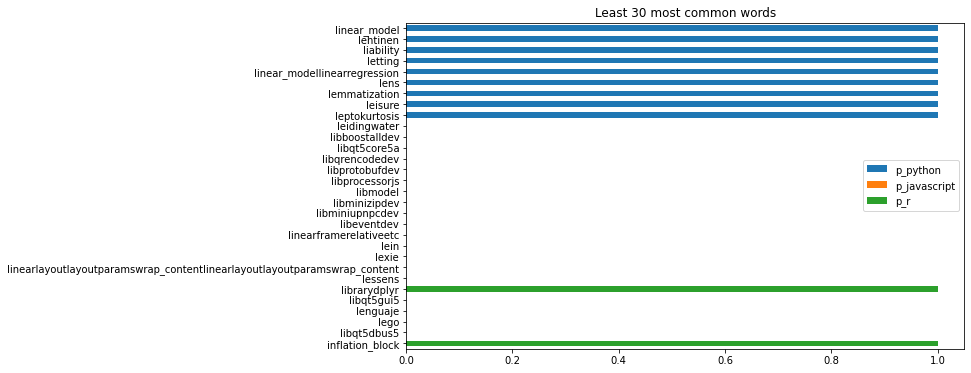

In [93]:
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_javascript=word_counts.javascript / word_counts['all'],
         p_r=word_counts.r / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_javascript','p_r']]
 .head(30)
 .sort_values('p_python')
 .plot.barh(stacked=True,figsize=(10, 6)))

plt.title('Least 30 most common words')

* True to an extent. When we look at the most common 20 words, they are fairly well distributed throughout the languages, but python only refers to python. If we look at the least common words, we see more stratification. For instance, 'librarydpylr' is only referenced in R language readmes because it imports an R statistics library.

## Exploration Summary:

From the exploration, we found that the unique word count and frequency do vary by different programming languages. Some specific words only refer to specific programming languages. The length of readme files has no relationship with the programming language.

## Modeling

In this project, we will use classification machine learning algorithms to fit the training data and evaluate it on validate set. Here I will use TF-IDF and bag of words with Decision Tree and Random Forest.

Then I will pick the best model using accuracy as the metric since accuracy is a good, easy to understand metric.

### Baseline

In [67]:
train.language.value_counts()

Other         123
Python        113
R              30
JavaScript     26
Name: language, dtype: int64

In [69]:
train['baseline'] = 'Other'
baseline_accuracy = (train.language == train.baseline).mean()
print(f'baseline accuracy on train set: {baseline_accuracy:.2%}')

baseline accuracy on train set: 42.12%


## Train
### 1. TF-IDF with Decision Tree and Random Forest

In [82]:
# definig TfidVectorizer for X and y
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df.lemmatized)
y = df.language
# split data
x_train, y_train, x_validate, y_validate, x_test, y_test = prepare.data_split_for_modeling(x, y)

# Desicion Tree fit on train
train1 = pd.DataFrame(dict(actual=y_train))
tree1 = DecisionTreeClassifier(max_depth=4).fit(x_train, y_train)
train1['tree_predicted'] = tree1.predict(x_train)

# Random Forest fit on train
train2 = pd.DataFrame(dict(actual=y_train))
forest1 = RandomForestClassifier(max_depth = 7, random_state= 123).fit(x_train, y_train)
train2['forest_predicted'] = forest1.predict(x_train)

print('TF-IDF Decision Tree (max depth = 4) on train Accuracy: {:.2%}'.format(accuracy_score(train1.actual, train1.tree_predicted)))
print('TF-IDF Random Forest (max depth = 7) on train Accuracy: {:.2%}'.format(accuracy_score(train2.actual, train2.forest_predicted)))

TF-IDF Decision Tree (max depth = 4) Accuracy: 62.67%
TF-IDF Random Forest (max depth = 7) Accuracy: 67.81%


### 2. Bag of words with Desicion Tree and Random Forest

In [86]:
# Count Vectorizer using bag of words - defining X & y variables
cv = CountVectorizer()
x1 = cv.fit_transform(df.lemmatized)
y1 = df.language

# split data
x_train1, y_train1, x_validate1, y_validate1, x_test1, y_test1 = prepare.data_split_for_modeling(x1, y1)

# Desicion Tree fit on train
train3 = pd.DataFrame(dict(actual=y_train1))
tree2 = DecisionTreeClassifier(max_depth=4).fit(x_train1, y_train1)
train3['tree_predicted'] = tree2.predict(x_train1)

# Random Forest fit on train
train4 = pd.DataFrame(dict(actual=y_train1))
forest2 = RandomForestClassifier(max_depth = 11, random_state= 123).fit(x_train1, y_train1)
train4['forest_predicted'] = forest2.predict(x_train1)

print('Bag of words Decision Tree (max depth = 4) on train Accuracy: {:.2%}'.format(accuracy_score(train3.actual, train3.tree_predicted)))
print('Bag of words Random Forest (max depth = 11) on train Accuracy: {:.2%}'.format(accuracy_score(train4.actual, train4.forest_predicted)))

Bag of words Decision Tree (max depth = 4) Accuracy: 61.64%
Bag of words Random Forest (max depth = 11) Accuracy: 72.95%


## Validate

Fit the best three models on validate set.

* TF-IDF Decision Tree (max depth = 4)
* TF-IDF Random Forest (max depth = 7)
* Bag of words Random Forest (max depth = 11)

In [88]:
# TF-IDF Decision Tree (max depth = 4)
validate1 = pd.DataFrame(dict(actual=y_validate))
validate1['tree_predicted'] = tree1.predict(x_validate)

# TF-IDF Random Forest (max depth = 7)
validate2 = pd.DataFrame(dict(actual=y_validate))
validate2['forest_predicted'] = forest1.predict(x_validate)

# Bag of words Random Forest (max depth = 11)
validate3 = pd.DataFrame(dict(actual=y_validate1))
validate3['forest_predicted'] = forest2.predict(x_validate1)

print('TF-IDF Decision Tree (max depth = 4) on Validate Accuracy: {:.2%}'.format(accuracy_score(validate1.actual, validate1.tree_predicted)))
print('TF-IDF Random Forest (max depth = 7) on Validate Accuracy: {:.2%}'.format(accuracy_score(validate2.actual, validate2.forest_predicted)))
print('Bag of words Random Forest (max depth = 11) on Validate Accuracy: {:.2%}'.format(accuracy_score(validate3.actual, validate3.forest_predicted)))

TF-IDF Decision Tree (max depth = 4) on Validate Accuracy: 53.17%
TF-IDF Random Forest (max depth = 7) on Validate Accuracy: 59.52%
Bag of words Random Forest (max depth = 11) on Validate Accuracy: 55.56%


## Test 
* Test with best model : TF-IDF Random Forest (max depth = 7)

In [90]:
# TF-IDF Random Forest (max depth = 7), rebuild the model and fit on test set

test = pd.DataFrame(dict(actual=y_test))
forest = RandomForestClassifier(max_depth = 7, random_state= 123).fit(x_train, y_train)
test['forest_predicted'] = forest.predict(x_test)
print('TF-IDF Random Forest (max depth = 7) on test set Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.forest_predicted)))

TF-IDF Random Forest (max depth = 7) on test set Accuracy: 51.43%


### Expectation
* According to the test result. I expect this model to perform with 51.43% accuracy in future data if there is no major change in our data source.

# Conclusion

## Summary

By exploring over 500+ Github READMEs programming languages related to the topic of inflation, we used TF-IDF method and built a Random Forest with max depth = 7 to predict the main programming language of those repos. The accuracy of the test set is 51.43%. Therefore, we will expect the same accuracy in future data with the same topic.

## Recommendations and Future Work

- adjust stop words to remove the words 'data' and 'inflation' to try and get more specific and unique wording for each language
- try different classification models such as KNN
- try unsupervised learning to see if there are any new insights into the different groupings of data